In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in data
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('store.csv')

In [4]:
# merge store data with train data
final = train.merge(stores, on='Store')

## Exploratory Analysis

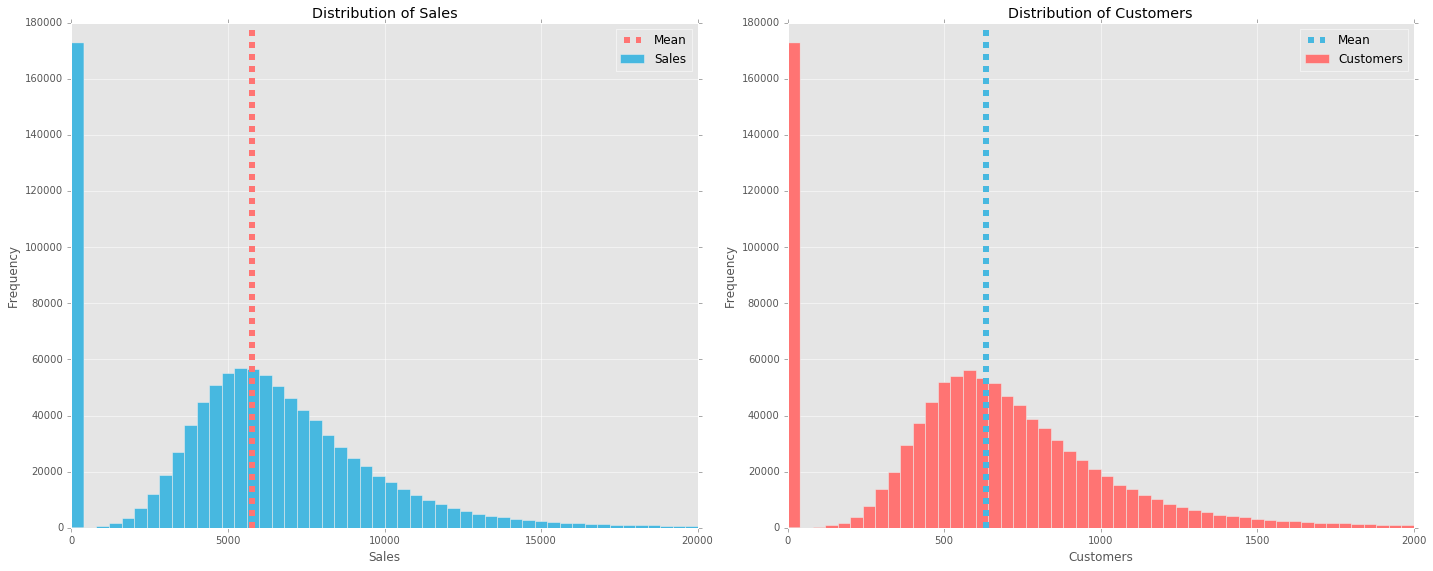

In [5]:
bins = 50
alpha = 1
fig = plt.figure(figsize=(20,8))

# SALES
plt.subplot(121)

plt.title("Distribution of Sales")
plt.ylabel('Frequency')
plt.xlabel('Sales')

sales = train.Sales
plt.hist(sales, color='#47b8e0', bins=bins, alpha=alpha, label = 'Sales', range = [0,20000])
plt.axvline(sales.mean(),color='#ff7473', linestyle='dashed', linewidth=6, label = 'Mean')
plt.legend(loc='upper right')

# CUSTOMERS
plt.subplot(122)

plt.title("Distribution of Customers")
plt.ylabel('Frequency')
plt.xlabel('Customers')

customers = train.Customers
plt.hist(customers, color='#ff7473', bins=bins, alpha=alpha, label = 'Customers', range = [0,2000])
plt.axvline(customers.mean(),color='#47b8e0', linestyle='dashed', linewidth=6, label = 'Mean')
plt.legend(loc='upper right')

plt.tight_layout()

### The distribution of Sales is extremely similar to the distribution of Customers. Intuitively, this makes a lot of sense.

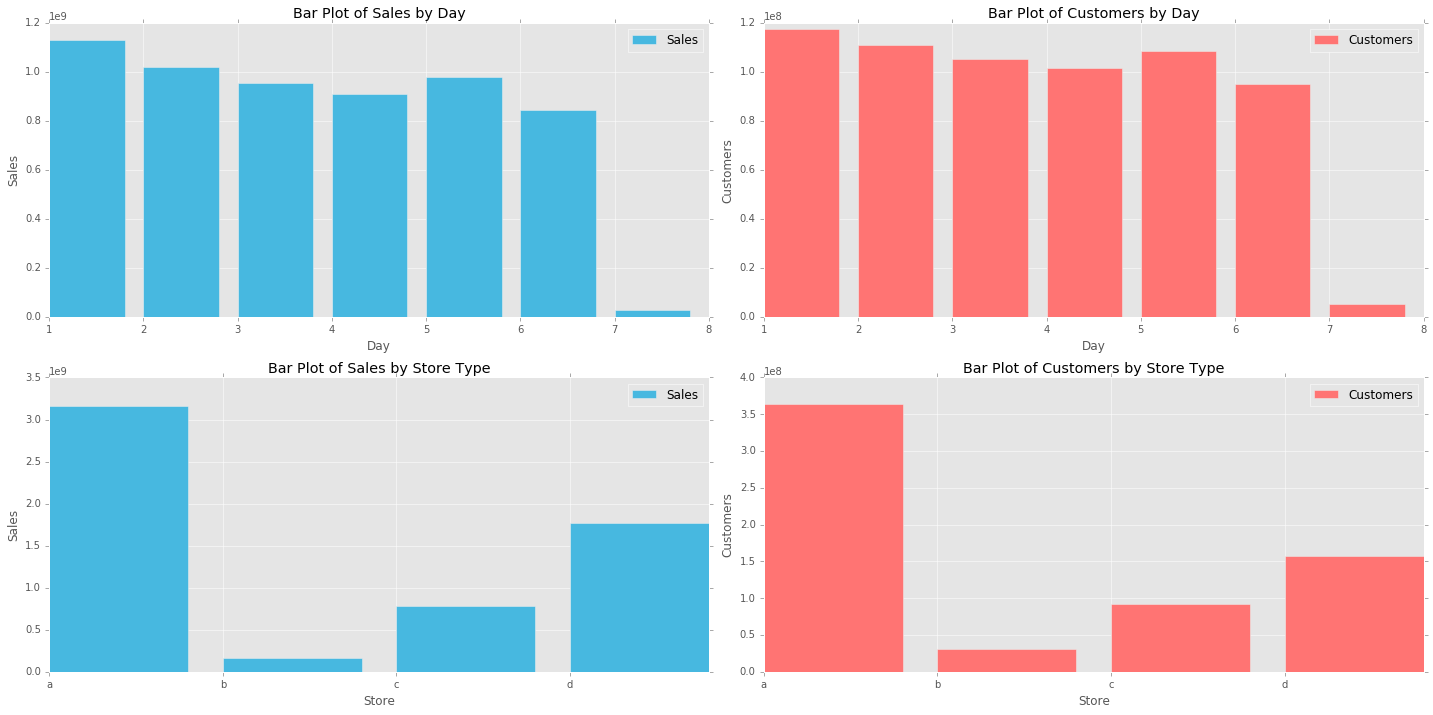

In [6]:
alpha = 1
fig = plt.figure(figsize=(20,10))

grouped_day = final.groupby(['DayOfWeek']).sum()
grouped_day = grouped_day.reset_index()

### DAY OF WEEK ###

# SALES BY DAY
plt.subplot(221)

plt.title("Bar Plot of Sales by Day")
plt.ylabel('Sales')
plt.xlabel('Day')

x = grouped_day.DayOfWeek
y = grouped_day.Sales

sales = train.Sales
plt.bar(x, y, color='#47b8e0', alpha=alpha, label = 'Sales')
plt.legend(loc='upper right')

# CUSTOMERS BY DAY
plt.subplot(222)

plt.title("Bar Plot of Customers by Day")
plt.ylabel('Customers')
plt.xlabel('Day')

x = grouped_day.DayOfWeek
y = grouped_day.Customers

plt.bar(x, y, color='#ff7473', alpha=alpha, label = 'Customers')
plt.legend(loc='upper right')

# ### STORE TYPE ###

grouped_store = final.groupby(['StoreType']).sum()
grouped_store = grouped_store.reset_index()

# SALES BY STORE
plt.subplot(223)

plt.title("Bar Plot of Sales by Store Type")
plt.ylabel('Sales')
plt.xlabel('Store')

labels = ['a', 'b', 'c', 'd']
plt.xticks(x-1, labels)

x = grouped_store.index
y = grouped_store.Sales

sales = train.Sales
plt.bar(x, y, color='#47b8e0', alpha=alpha, label = 'Sales')
plt.legend(loc='upper right')

# CUSTOMERS BY STORE
plt.subplot(224)

plt.title("Bar Plot of Customers by Store Type")
plt.ylabel('Customers')
plt.xlabel('Store')

labels = ['a', 'b', 'c', 'd']
plt.xticks(x, labels)

x = grouped_store.index
y = grouped_store.Customers

plt.bar(x, y, color='#ff7473', alpha=alpha, label = 'Customers')
plt.legend(loc='upper right')

plt.tight_layout()

### These plots give an example of how some of the features could influence the Sales/Customers of a particular store. We can see that certain days are more popular for shipping, and there is a lot of discrepancy between Store Type for Sales/Customers.

In [7]:
final['Date'] = pd.to_datetime(final['Date'])

final['year_month'] = final['Date'].dt.year.map(str) + '-' + final['Date'].dt.month.map(str)

grouped_month = final.groupby(final['year_month']).sum()
grouped_month = grouped_month.reset_index()

grouped_month['year_month'] = pd.to_datetime(grouped_month['year_month'])

grouped_month = grouped_month.sort_values(by='year_month')
grouped_month = grouped_month.reset_index()

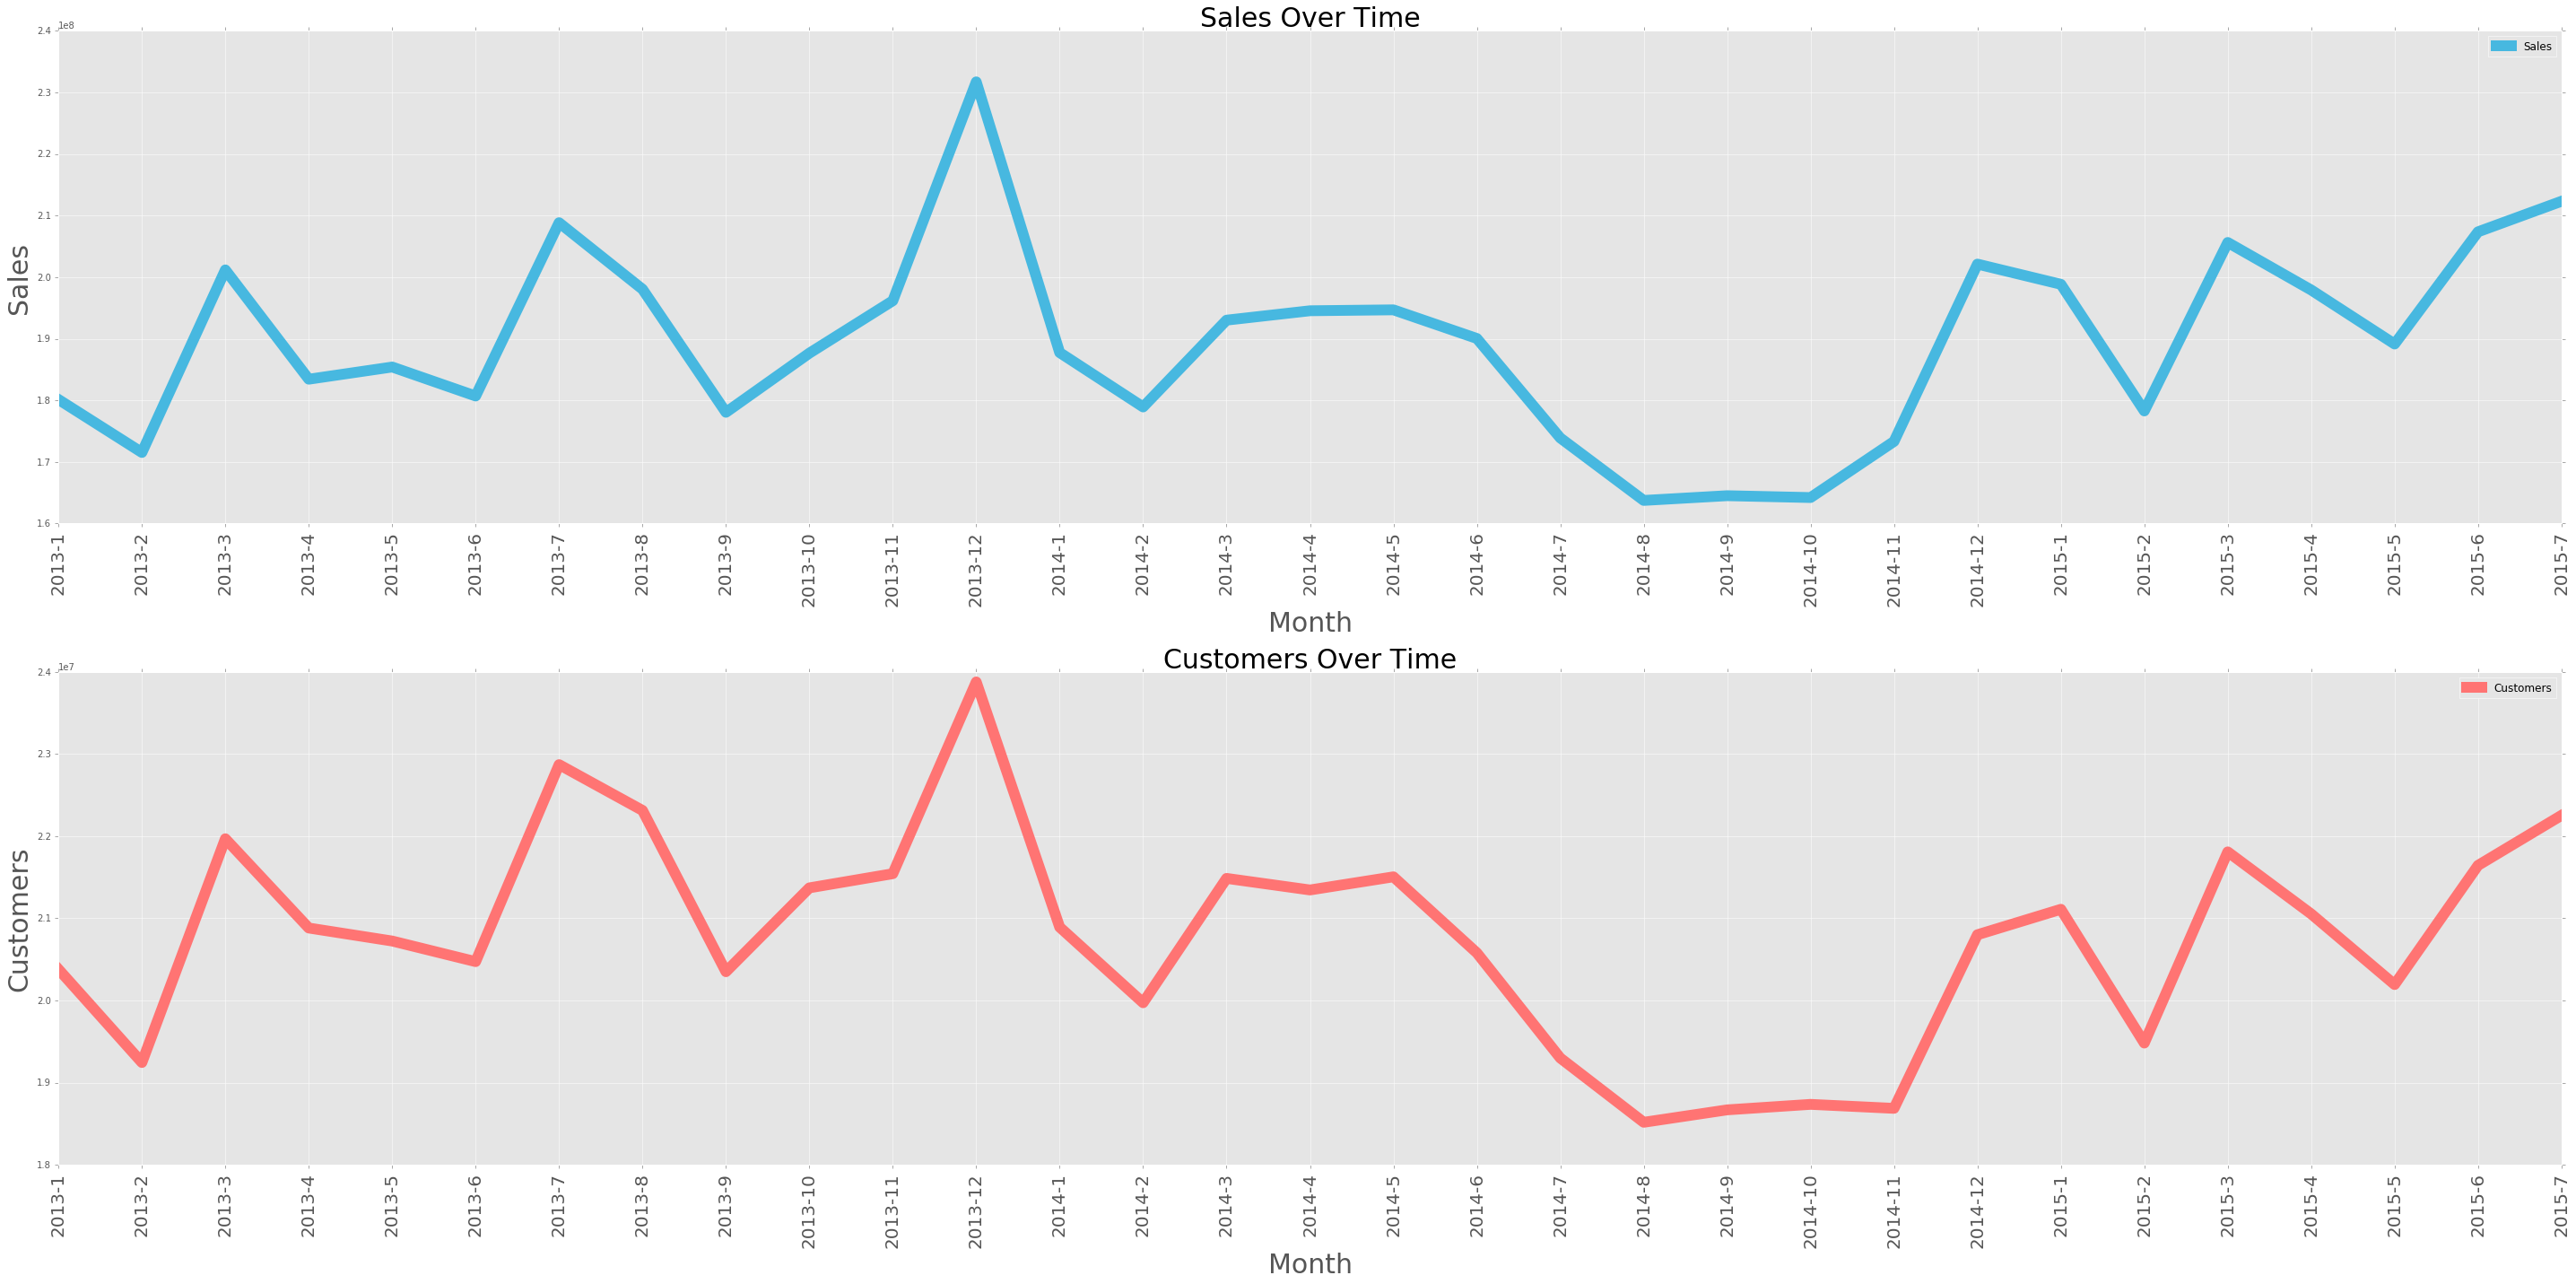

In [8]:
alpha = 1
fig = plt.figure(figsize=(40,20))

### DAY OF WEEK ###

# SALES BY DAY
plt.subplot(211)

plt.title("Sales Over Time", size = 30)
plt.ylabel('Sales', size = 30)
plt.xlabel('Month', size = 30)

x = grouped_month.index
y = grouped_month.Sales

labels = grouped_month['year_month'].dt.year.map(str) + '-' + grouped_month['year_month'].dt.month.map(str)
plt.xticks(x, labels, rotation='vertical', size = 20)

sales = train.Sales
plt.plot(x, y, color='#47b8e0', alpha=alpha, label = 'Sales', linewidth=12)
plt.legend(loc='upper right')

### DAY OF WEEK ###

# SALES BY DAY
plt.subplot(212)

plt.title("Customers Over Time", size = 30)
plt.ylabel('Customers', size = 30)
plt.xlabel('Month', size = 30)

x = grouped_month.index
y = grouped_month.Customers

labels = grouped_month['year_month'].dt.year.map(str) + '-' + grouped_month['year_month'].dt.month.map(str)
plt.xticks(x, labels, rotation='vertical', size = 20)

plt.plot(x, y, color='#ff7473', alpha=alpha, label = 'Customers', linewidth=12)
plt.legend(loc='upper right')
plt.tight_layout()

### These plots illustrate how Sales/Customers are affected over time by a variety of factors, and demonstrate that there is no simple linear relationship between time and Sales/Customers.

## Data Normalization

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.cross_validation  import train_test_split
from keras.optimizers import SGD
import numpy as np

Using Theano backend.


In [10]:
# limit the model to the first 10,000 samples - for ease of computation
train_cut = final.iloc[:50000, :]

In [11]:
# convert Store to float16 for faster runtime
train_cut['Store'] = train_cut['Store'].astype(np.float16)

In [12]:
# convert catigorical variables to dummy indicators
train_2 = pd.get_dummies(train_cut, columns=['Store', 'DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment', 'year_month'])

In [13]:
# drop extraneous features
train_2.drop(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'], axis=1, inplace=True)

In [14]:
# normalize label
labels = (train_2['Sales'] - train_2['Sales'].mean(axis=0)) / train_2['Sales'].std(axis=0, ddof=1)

In [15]:
# remove label columns from training set
train_2 = train_2.iloc[:, 3:]

In [16]:
# convert to float16 for faster runtime
train_2 = train_2.astype(np.float16)
labels = labels.astype(np.float16)

## Neural Network 

In [17]:
# split data in training and test
x_train, x_valid, y_train, y_valid  = train_test_split(train_2, 
                                                     labels, 
                                                     test_size=0.30, 
                                                     random_state=42)

In [18]:
# convert DataFrame to numpy array
x_train = x_train.values
y_train = y_train.values

x_valid = x_valid.values
y_valid = y_valid.values

In [19]:
# build sequential neural network model with:
# 150 hidden units
# 0.2 dropout regularizer
# tanh activation function
# mean squared error loss function
# stochastic gradient descent optimizer

model = Sequential()
model.add(Dense(output_dim=150, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('tanh'))
model.add(Dense(output_dim=1))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mean_squared_error', optimizer='sgd')

In [20]:
# fit model to data
history = model.fit(x_train, y_train, 
                    verbose=0, 
                    nb_epoch=2000, 
                    batch_size=500,
                    validation_data=(x_valid, y_valid))

## Results - Training/Validation

In [21]:
score = model.evaluate(x_train, y_train, batch_size=2000)
print 'Training error %f' % (score)
print ''

score = model.evaluate(x_valid, y_valid, batch_size=2000)
print 'Validation error %f' % (score)

35000/35000 [==============================] - 0s     
Training error 0.130856

15000/15000 [==============================] - 0s     
Validation error 0.133867


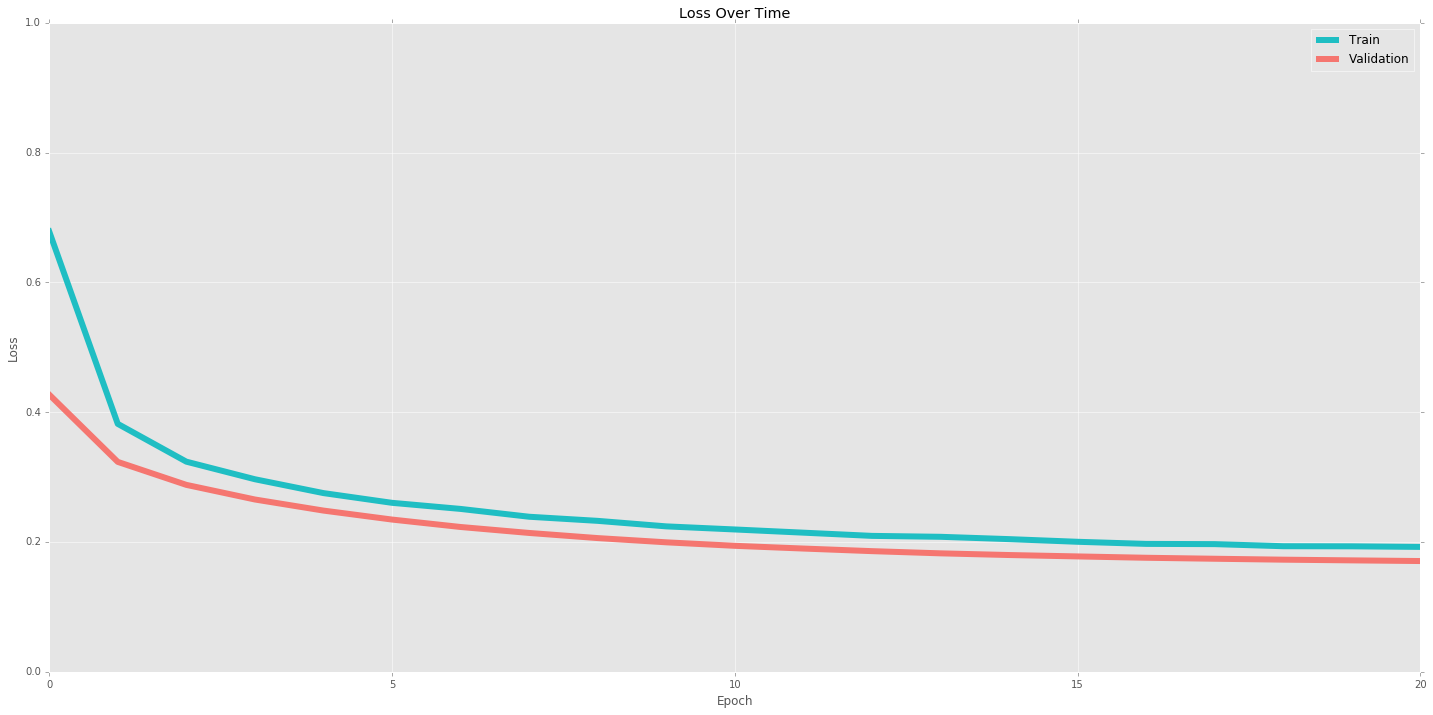

In [24]:
fig = plt.figure(figsize=(20,10))
plt.subplot(111)
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.xlim([0,20])
    
train = plt.plot(history.epoch, history.history['loss'], color='#1FBEC3', label='Train', linewidth=6)
val = plt.plot(history.epoch, history.history['val_loss'], color='#F57670', label='Validation', linewidth=6)
plt.legend(loc='upper right')

plt.tight_layout()

### Overall, the model has a relatively small error for both the Training and Validation sets for the small sample used. Using all 1 million rows would no doubt further reduce this error.